# Medical Text Processer

Medical decision-making processes are increasingly relying on data-driven approaches to enhance accuracy and efficiency. The [California Department of Managed Health Care(DMHC)](https://www.dmhc.ca.gov/) provides a valuable [dataset](https://www.kaggle.com/datasets/prasad22/ca-independent-medical-review/data) that encompasses all decisions from Independent Medical Reviews (IMRs) conducted since January 1, 2001. An IMR involves an independent evaluation of health care service requests that have been denied, delayed, or altered by health plans based on claims of non-medical necessity, experimental nature, or non-urgent status. When an IMR favors the enrollee, the health plan is required to authorize the requested service or treatment.

In this context, predictive models trained on medical text data can significantly improve the precision of treatment and diagnostic decisions. This project aims to develop and evaluate two distinct machine learning models: one for predicting medical treatments and the other for diagnosing conditions based on IMR data. The project will involve preprocessing the extensive text data, feature extraction, and model training using natural language processing techniqes. The goal is to enhance decision-making by providing reliable predictions that can support both treatment recommendations and diagnostic accuracy.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

### Loading Data

In [6]:
text_data = pd.read_csv('Independent_Medical_Reviews.csv')

In [7]:
text_data

,Reference ID,Report Year,Diagnosis Category,Diagnosis Sub Category,Treatment Category,Treatment Sub Category,Determination,Type,Age Range,Patient Gender,Findings
0,MN16-22639,2016,Infectious,Hepatitis,Pharmacy/Prescription Drugs,Anti-virals,Overturned Decision of Health Plan,Medical Necessity,41-50,Male,Nature of Statutory Criteria/Case Summary: An ...
1,MN16-22638,2016,Mental,Eating Disorder,Mental Health Treatment,Residential Treatment Center - Admission,Upheld Decision of Health Plan,Medical Necessity,21-30,Female,Nature of Statutory Criteria/Case Summary: An...
2,MN16-22637,2016,Autism Spectrum,Autism-PDD-NOS,Autism Related Treatment,Speech Therapy,Upheld Decision of Health Plan,Medical Necessity,0-10,Female,Nature of Statutory Criteria/Case Summary: Th...
3,EI16-22636,2016,Prevention/Good Health,NaN,"Diagnostic Imaging, Screening and Testing",Mammography,Overturned Decision of Health Plan,Experimental/Investigational,65+,Female,Nature of Statutory Criteria/Case Summary: An ...
4,EI06-5319,2006,Cardiac/Circulatory,NaN,Cardio Vascular,NaN,Upheld Decision of Health Plan,Experimental/Investigational,51-64,Male,Physician 1: The patient is a 62-year-old male...
...,...,...,...,...,...,...,...,...,...,...,...
19240,MN01-7,2001,Trauma/Injuries,Gunshot Wound,Neurosugery,Cranioplasty,Overturned Decision of Health Plan,Medical Necessity,NaN,NaN,The parents of a 17-year-old male requested a ...
19241,MN01-6,2001,Infectious,Onychomycosis/ Nail Fungus,Pharmacy/Prescription Drugs,Anti-Fungal,Upheld Decision of Health Plan,Medical Necessity,NaN,NaN,A 46-year-old male requested Penlac lacquer fo...
19242,MN01-5,2001,Orthopedic/ Musculoskeletal,Other,Orthopedic,Arthroscopy,Upheld Decision of Health Plan,Medical Necessity,NaN,NaN,A 46-year-old female requested an orthoscopic ...
19243,MN01-4,2001,Orthopedic/ Musculoskeletal,Back Pain,Reconstructive/Plastic Surgery,Breast Reduction,Overturned Decision of Health Plan,Medical Necessity,NaN,NaN,A 24-year-old female requested a bilateral bre...


### Exploratory Data Analysis / Data Visualization

In [9]:
diagnostic_target_data = text_data[['Findings', 'Diagnosis Category']].dropna()
diagnostic_target_data = diagnostic_target_data[diagnostic_target_data['Diagnosis Category']!='Not Applicable']
diagnostic_target_data

,Findings,Diagnosis Category
0,Nature of Statutory Criteria/Case Summary: An ...,Infectious
1,Nature of Statutory Criteria/Case Summary: An...,Mental
2,Nature of Statutory Criteria/Case Summary: Th...,Autism Spectrum
3,Nature of Statutory Criteria/Case Summary: An ...,Prevention/Good Health
4,Physician 1: The patient is a 62-year-old male...,Cardiac/Circulatory
...,...,...
19240,The parents of a 17-year-old male requested a ...,Trauma/Injuries
19241,A 46-year-old male requested Penlac lacquer fo...,Infectious
19242,A 46-year-old female requested an orthoscopic ...,Orthopedic/ Musculoskeletal
19243,A 24-year-old female requested a bilateral bre...,Orthopedic/ Musculoskeletal


The 'Findings' feature, which contains case summaries and patient assessment information for each patient in a textual paragraph form, will be used to train the models. The 'Diagnosis Category' and 'Treatment Category' columns will be used as target labels for the 2 models, respectively.

In [11]:
diagnoses = diagnostic_target_data.drop_duplicates('Diagnosis Category')
print(diagnoses['Diagnosis Category'])

0                                   Infectious
1                                       Mental
2                              Autism Spectrum
3                       Prevention/Good Health
4                          Cardiac/Circulatory
6                            OB-Gyn/ Pregnancy
9           Digestive System/ Gastrointestinal
12                 Orthopedic/ Musculoskeletal
15       Central Nervous System/ Neuromuscular
16                        Endocrine/ Metabolic
41                                  Pediatrics
50                                Chronic Pain
51                          Respiratory System
52                                      Cancer
61                              Morbid Obesity
63                          Ears, Nose, Throat
77                  Post Surgical Complication
82                                 Immunologic
95                                        Skin
146                                       Foot
148                                     Dental
160          

Here, patients with missing data, along with duplicate patient observations, have been dropped from the dataset.

In [13]:
diagnostic_categories = diagnoses['Diagnosis Category'].to_numpy()
print(diagnostic_categories)

['Infectious' 'Mental' 'Autism Spectrum' 'Prevention/Good Health'
 'Cardiac/Circulatory' 'OB-Gyn/ Pregnancy'
 'Digestive System/ Gastrointestinal' 'Orthopedic/ Musculoskeletal'
 'Central Nervous System/ Neuromuscular' 'Endocrine/ Metabolic'
 'Pediatrics' 'Chronic Pain' 'Respiratory System' 'Cancer'
 'Morbid Obesity' 'Ears, Nose, Throat' 'Post Surgical Complication'
 'Immunologic' 'Skin' 'Foot' 'Dental' 'Blood Related' 'Genetic'
 'Genitourinary/ Kidney' 'Vision' 'Trauma/Injuries' 'Organ Failure'
 'Alcohol and Drug Addiction']


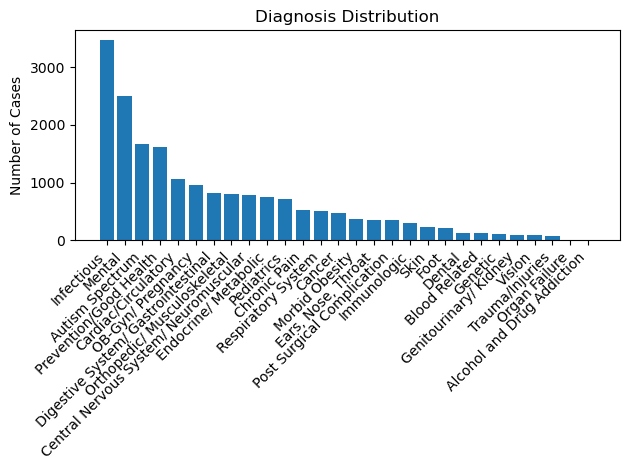

In [14]:
fig, ax = plt.subplots()
counts = diagnostic_target_data['Diagnosis Category'].value_counts()
ax.bar(diagnostic_categories, counts)
ax.set_ylabel('Number of Cases')
ax.set_title('Diagnosis Distribution')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

In [15]:
treatment_target_data = text_data[['Findings', 'Treatment Category']].dropna()
treatment_target_data = treatment_target_data[treatment_target_data['Treatment Category']!='Not Applicable']
treatment_target_data

,Findings,Treatment Category
0,Nature of Statutory Criteria/Case Summary: An ...,Pharmacy/Prescription Drugs
1,Nature of Statutory Criteria/Case Summary: An...,Mental Health Treatment
2,Nature of Statutory Criteria/Case Summary: Th...,Autism Related Treatment
3,Nature of Statutory Criteria/Case Summary: An ...,"Diagnostic Imaging, Screening and Testing"
4,Physician 1: The patient is a 62-year-old male...,Cardio Vascular
...,...,...
19240,The parents of a 17-year-old male requested a ...,Neurosugery
19241,A 46-year-old male requested Penlac lacquer fo...,Pharmacy/Prescription Drugs
19242,A 46-year-old female requested an orthoscopic ...,Orthopedic
19243,A 24-year-old female requested a bilateral bre...,Reconstructive/Plastic Surgery


In [16]:
treatments = treatment_target_data.drop_duplicates('Treatment Category')
print(treatments['Treatment Category'])

0                            Pharmacy/Prescription Drugs
1                                Mental Health Treatment
2                               Autism Related Treatment
3              Diagnostic Imaging, Screening and Testing
4                                        Cardio Vascular
12                             Durable Medical Equipment
16                       Diagnostic/Physician Evaluation
24                                            Orthopedic
29                                 Emergency/Urgent Care
34                                       General Surgery
39                   Acute Medical Services - Outpatient
50                                       Pain Management
52                                      Cancer Treatment
75                        Reconstructive/Plastic Surgery
78     Rehabilitation Services - Skilled Nursing Faci...
86                                     Special Procedure
87         Electrical/ Thermal/ Radiofreq. Interventions
101                            

In [17]:
treatment_categories = treatments['Treatment Category'].to_numpy()
print(treatment_categories)

['Pharmacy/Prescription Drugs' 'Mental Health Treatment'
 'Autism Related Treatment' 'Diagnostic Imaging, Screening and Testing'
 'Cardio Vascular' 'Durable Medical Equipment'
 'Diagnostic/Physician Evaluation' 'Orthopedic' 'Emergency/Urgent Care'
 'General Surgery' 'Acute Medical Services - Outpatient' 'Pain Management'
 'Cancer Treatment' 'Reconstructive/Plastic Surgery'
 'Rehabilitation Services - Skilled Nursing Facility - Inpatient'
 'Special Procedure' 'Electrical/ Thermal/ Radiofreq. Interventions'
 'Alternative Treatment' 'OB/GYN Procedures' 'Neurosugery'
 'Dental/Orthodontic' 'Home Health Care'
 'Acute Medical Services - Inpatient' 'Ear, Nose and Throat Procedures'
 'Rehabilitation Services - Outpatient' 'Vision' 'Urology'
 'Preventive Health Screening' 'Chiropractic' 'Ophthalmology']


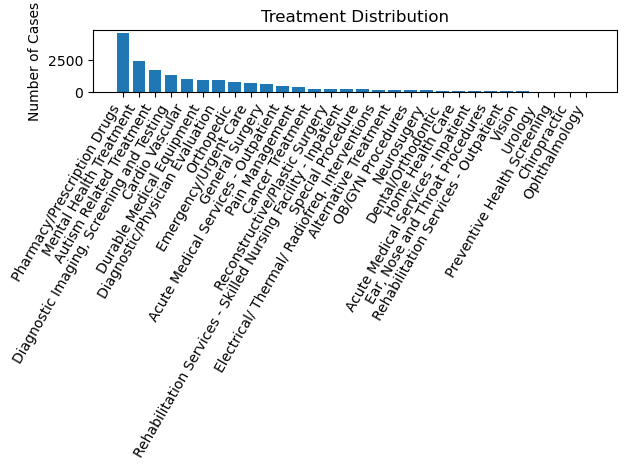

In [18]:
fig, ax = plt.subplots()
counts = treatment_target_data['Treatment Category'].value_counts()
ax.bar(treatment_categories, counts)
ax.set_ylabel('Number of Cases')
ax.set_title('Treatment Distribution')
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.tight_layout()
plt.show()

Both target features show obvious class imbalance. However, oversampling with text data is beyond the scope of this project and could potentially be addressed for future enhancement of the models.

## Model 1: Medical Diagnosis Text Classification

### Building Data Pipeline

In [22]:
diagnostic_target_data['Diagnosis Category'], factorized_diagnosis_categories = pd.factorize(diagnostic_target_data['Diagnosis Category'])

Factorizing the target data allows the array to take on a numerical representation. This will simply its input into the model architecture.

In [24]:
diagnostic_target_data

,Findings,Diagnosis Category
0,Nature of Statutory Criteria/Case Summary: An ...,0
1,Nature of Statutory Criteria/Case Summary: An...,1
2,Nature of Statutory Criteria/Case Summary: Th...,2
3,Nature of Statutory Criteria/Case Summary: An ...,3
4,Physician 1: The patient is a 62-year-old male...,4
...,...,...
19240,The parents of a 17-year-old male requested a ...,25
19241,A 46-year-old male requested Penlac lacquer fo...,0
19242,A 46-year-old female requested an orthoscopic ...,7
19243,A 24-year-old female requested a bilateral bre...,7


In [25]:
num_diagnostic_classes = len(factorized_diagnosis_categories)

In [26]:
from tensorflow.keras.utils import to_categorical
diagnosis_output_one_hot = to_categorical(diagnostic_target_data['Diagnosis Category'], num_classes=num_diagnostic_classes)

In [27]:
diagnosis_input = diagnostic_target_data['Findings']
diagnosis_output = diagnosis_output_one_hot
diagnosis_dataset = tf.data.Dataset.from_tensor_slices((diagnosis_input, diagnosis_output))

One Hot Encoding: Due to the mixed nature of the dataset being used, the technique of one hot encoding is employed to represent categorical features as numerical features, allowing for uniform numerical input into the machine learning models.

In [29]:
diagnosis_dataset = diagnosis_dataset.batch(64).shuffle(buffer_size = 1000).cache().prefetch(buffer_size = tf.data.AUTOTUNE)

Batching: Grouping data samples together to be processed simultaneously for optimized model training.

Caching: Storing data temporarily in memory to avoid redundant loading and speed up access.

Prefetching: Loading data in advance while the model processes the current batch to reduce idle time.

### Text Vectorization

Text Vectorization: the process of converting raw text data into numerical representations/vectors that machine learning models can be trained on.

In [35]:
vocab_size = 5000
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size)
data_input = diagnosis_dataset.map(lambda x,y: x)
text_vectorizer.adapt(data_input)

In [36]:
original_text = diagnostic_target_data['Findings'][0]
vocab = np.array(text_vectorizer.get_vocabulary())
text_vectors = text_vectorizer(original_text).numpy()
transcript = ' '.join(vocab[text_vectors])
print(f'Original text: {original_text}')
print('\n')
print(f'tokens: {text_vectors}')
print('\n')
print(f'Transcript: {transcript}')

Original text: Nature of Statutory Criteria/Case Summary: An enrollee has requested Harvoni for treatment of his hepatitis C virus genotype 1a.  Findings:  The physician reviewer found that according to the most recent joint guidelines issued by the American Association for the Study of Liver Diseases (AASLD) and the Infectious Diseases Society of America (IDSA), all patients with chronic hepatitis C should be treated except those with limited life expectancy due to non-liver-related conditions. This applies regardless of fibrosis stage or viral load, and advanced fibrosis is not required for treatment. Per guidelines, treatment-naïve genotype 1 patients should be treated with Harvoni. Patients with viral load of less than 6,000,000 IU/mL can be treated for eight weeks. These guideline recommendations are based on multiple randomized clinical trials (Kowdley, et al; Afdhal, et al). Moreover, the AASLD and IDSA guidelines cite data showing reduced survival with delayed treatment (Jezequ

The Keras TextVectorization layer maps text features to integer sequences. Above is an example of a tokenized representation of a case summary from the dataset, along with its transcript in text form

### Splitting Data

In [39]:
train_size = 0.8
num_batches = diagnosis_dataset.cardinality().numpy()
num_train_batches = int(num_batches * train_size)
num_validation_batches = num_batches - num_train_batches - 1
num_test_batches = 1

train_ds = diagnosis_dataset.take(num_train_batches)
validation_ds = diagnosis_dataset.skip(num_train_batches).take(num_validation_batches)
diagnosis_test_ds = diagnosis_dataset.skip(num_train_batches).skip(num_validation_batches)

print(f'Number of training batches: {train_ds.cardinality().numpy()}')
print(f'Number of validation batches: {validation_ds.cardinality().numpy()}')
print(f'Number of testing batches: {diagnosis_test_ds.cardinality().numpy()}')

Number of training batches: 239
Number of validation batches: 59
Number of testing batches: 1


Divides the data into 3 subsets:

Training set - used to train the model

Validation set - intermediary set used for fine-tuning the models and preventing overfitting; while training, it periodically helps assess how well the models generalize to data they haven't been trained on

Testing set - used to test the model on new data

### Building Model

In [45]:
diagnosis_model = tf.keras.Sequential([
    text_vectorizer,
    tf.keras.layers.Embedding(vocab_size, 128, mask_zero=True),
    tf.keras.layers.SpatialDropout1D(0.3),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.LayerNormalization(), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4), 
    tf.keras.layers.Dense(num_diagnostic_classes, activation='softmax')
])

Text Vectorizer: Converts raw text into numerical sequences (tokens) for model input.

Embedding Layer: Maps each token to a dense, continuous vector representation for semantic processing.

SpatialDropout1D: Drops entire embedded feature maps randomly to reduce overfitting on 1D sequence data.

Bidirectional LSTM: Processes sequence data in both forward and backward directions to capture full context, returning sequences.

LayerNormalization: Normalizes inputs across features to stabilize training and improve convergence.

Dense Layer: Standard fully connected layer neural network layer.

Dropout Layer: Randomly drops connections to prevent overfitting during training.

In [53]:
diagnosis_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

Adam Optimizer: An adaptive learning rate optimization algorithm that combines the benefits of both momentum and RMSProp for faster and more efficient training.

Categorical Crossentropy Loss: A loss function used for multi-class classification tasks that measures the difference between the predicted probability distribution and the true class distribution.

In [56]:
diagnosis_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 spatial_dropout1d (Spatial  (None, None, 128)         0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 layer_normalization (Layer  (None, None, 256)         512       
 Normalization)                                         

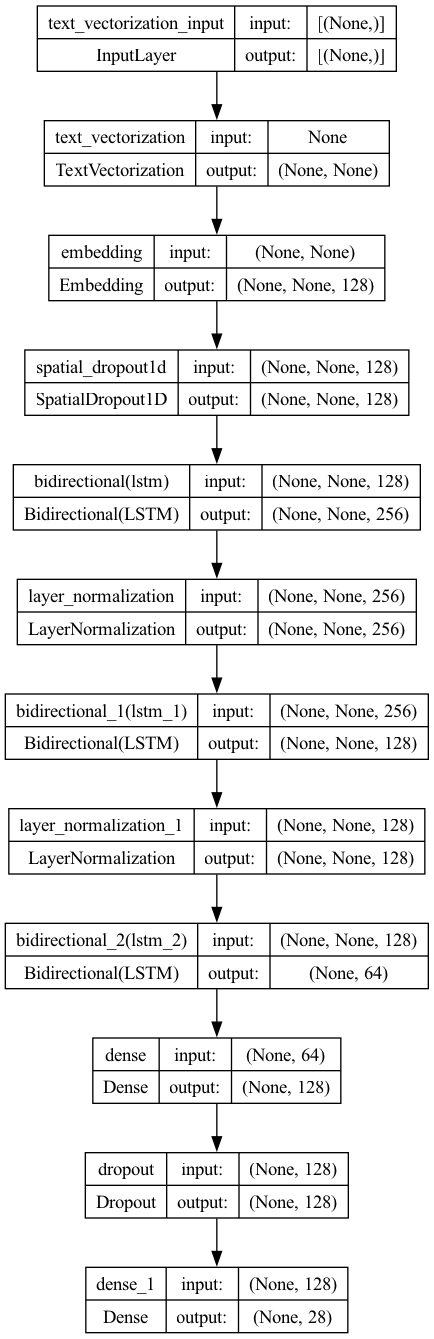

In [57]:
tf.keras.utils.plot_model(diagnosis_model, "diagnosis_model.png", show_shapes=True)

### Training Model

In [59]:
cb = [EarlyStopping(patience=5, monitor='val_accuracy', verbose = 1, restore_best_weights=True)]
history = diagnosis_model.fit(train_ds, epochs=100, validation_data = validation_ds, callbacks = cb )

Epoch 1/100
239/239 [==============================] - 319s 1s/step - loss: 2.3514 - accuracy: 0.3505 - val_loss: 1.6666 - val_accuracy: 0.5808
Epoch 2/100
239/239 [==============================] - 321s 1s/step - loss: 1.5731 - accuracy: 0.5829 - val_loss: 1.3355 - val_accuracy: 0.6488
Epoch 3/100
239/239 [==============================] - 311s 1s/step - loss: 1.3021 - accuracy: 0.6583 - val_loss: 1.1658 - val_accuracy: 0.6888
Epoch 4/100
239/239 [==============================] - 307s 1s/step - loss: 1.1081 - accuracy: 0.7124 - val_loss: 1.0428 - val_accuracy: 0.7336
Epoch 5/100
239/239 [==============================] - 303s 1s/step - loss: 0.9747 - accuracy: 0.7514 - val_loss: 0.9686 - val_accuracy: 0.7564
Epoch 6/100
239/239 [==============================] - 311s 1s/step - loss: 0.8734 - accuracy: 0.7766 - val_loss: 0.9271 - val_accuracy: 0.7715
Epoch 7/100
239/239 [==============================] - 325s 1s/step - loss: 0.7826 - accuracy: 0.7997 - val_loss: 0.9222 - val_accuracy:

## Model 2: Medical Treatment Text Classification

### Building Data Pipeline

In [62]:
treatment_target_data['Treatment Category'], factorized_treatment_categories = pd.factorize(treatment_target_data['Treatment Category'])

In [63]:
treatment_target_data

,Findings,Treatment Category
0,Nature of Statutory Criteria/Case Summary: An ...,0
1,Nature of Statutory Criteria/Case Summary: An...,1
2,Nature of Statutory Criteria/Case Summary: Th...,2
3,Nature of Statutory Criteria/Case Summary: An ...,3
4,Physician 1: The patient is a 62-year-old male...,4
...,...,...
19240,The parents of a 17-year-old male requested a ...,19
19241,A 46-year-old male requested Penlac lacquer fo...,0
19242,A 46-year-old female requested an orthoscopic ...,7
19243,A 24-year-old female requested a bilateral bre...,13


In [64]:
num_treatment_classes = len(factorized_treatment_categories)

In [65]:
treatment_output_one_hot = to_categorical(treatment_target_data['Treatment Category'], num_classes=num_treatment_classes)

In [66]:
treatment_input = treatment_target_data['Findings']
treatment_output = treatment_output_one_hot
treatment_dataset = tf.data.Dataset.from_tensor_slices((treatment_input, treatment_output))

In [67]:
treatment_dataset = treatment_dataset.batch(64).shuffle(buffer_size = 1000).cache().prefetch(buffer_size = tf.data.AUTOTUNE)

### Text Vectorization

In [69]:
data_input = treatment_dataset.map(lambda x,y: x)
text_vectorizer.adapt(data_input)

In [70]:
original_text = treatment_target_data['Findings'][0]
vocab = np.array(text_vectorizer.get_vocabulary())
text_vectors = text_vectorizer(original_text).numpy()
transcript = ' '.join(vocab[text_vectors])
print(f'Original text: {original_text}')
print('\n')
print(f'tokens: {text_vectors}')
print('\n')
print(f'Transcript: {transcript}')

Original text: Nature of Statutory Criteria/Case Summary: An enrollee has requested Harvoni for treatment of his hepatitis C virus genotype 1a.  Findings:  The physician reviewer found that according to the most recent joint guidelines issued by the American Association for the Study of Liver Diseases (AASLD) and the Infectious Diseases Society of America (IDSA), all patients with chronic hepatitis C should be treated except those with limited life expectancy due to non-liver-related conditions. This applies regardless of fibrosis stage or viral load, and advanced fibrosis is not required for treatment. Per guidelines, treatment-naïve genotype 1 patients should be treated with Harvoni. Patients with viral load of less than 6,000,000 IU/mL can be treated for eight weeks. These guideline recommendations are based on multiple randomized clinical trials (Kowdley, et al; Afdhal, et al). Moreover, the AASLD and IDSA guidelines cite data showing reduced survival with delayed treatment (Jezequ

### Splitting Data

In [72]:
train_size = 0.8
num_batches = treatment_dataset.cardinality().numpy()
num_train_batches = int(num_batches * train_size)
num_validation_batches = num_batches - num_train_batches - 1
num_test_batches = 1

train_ds = treatment_dataset.take(num_train_batches)
validation_ds = treatment_dataset.skip(num_train_batches).take(num_validation_batches)
test_ds = treatment_dataset.skip(num_train_batches).skip(num_validation_batches)

print(f'Number of training batches: {train_ds.cardinality().numpy()}')
print(f'Number of validation batches: {validation_ds.cardinality().numpy()}')
print(f'Number of testing batches: {test_ds.cardinality().numpy()}')

Number of training batches: 234
Number of validation batches: 58
Number of testing batches: 1


### Building Model

In [74]:
treatment_model = tf.keras.Sequential([
    text_vectorizer,
    tf.keras.layers.Embedding(vocab_size, 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_treatment_classes, activation='softmax')
])

In [75]:
treatment_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

In [76]:
treatment_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional_3 (Bidirecti  (None, None, 256)         263168    
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                      

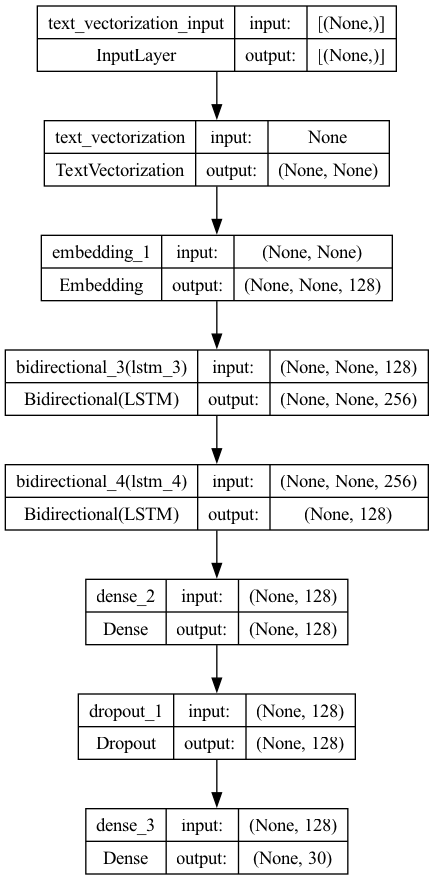

In [77]:
tf.keras.utils.plot_model(treatment_model, "treatment_model.png", show_shapes=True)

### Training Model

In [79]:
cb = [EarlyStopping(patience=5, monitor='val_accuracy', verbose = 1, restore_best_weights=True)]
history2 = treatment_model.fit(train_ds, epochs=100, validation_data = validation_ds, callbacks = cb )

Epoch 1/100
234/234 [==============================] - 222s 934ms/step - loss: 2.3807 - accuracy: 0.3338 - val_loss: 1.5474 - val_accuracy: 0.5762
Epoch 2/100
234/234 [==============================] - 206s 883ms/step - loss: 1.3262 - accuracy: 0.6631 - val_loss: 1.0558 - val_accuracy: 0.7317
Epoch 3/100
234/234 [==============================] - 218s 934ms/step - loss: 1.0300 - accuracy: 0.7390 - val_loss: 0.9437 - val_accuracy: 0.7616
Epoch 4/100
234/234 [==============================] - 221s 946ms/step - loss: 0.8525 - accuracy: 0.7814 - val_loss: 0.9769 - val_accuracy: 0.7470
Epoch 5/100
234/234 [==============================] - 223s 957ms/step - loss: 0.7558 - accuracy: 0.8085 - val_loss: 0.9261 - val_accuracy: 0.7740
Epoch 6/100
234/234 [==============================] - 1171s 5s/step - loss: 0.6629 - accuracy: 0.8306 - val_loss: 0.9501 - val_accuracy: 0.7756
Epoch 7/100
234/234 [==============================] - 1218s 5s/step - loss: 0.6099 - accuracy: 0.8469 - val_loss: 0.932

### Testing Models

In [81]:
from sklearn.metrics import confusion_matrix, classification_report

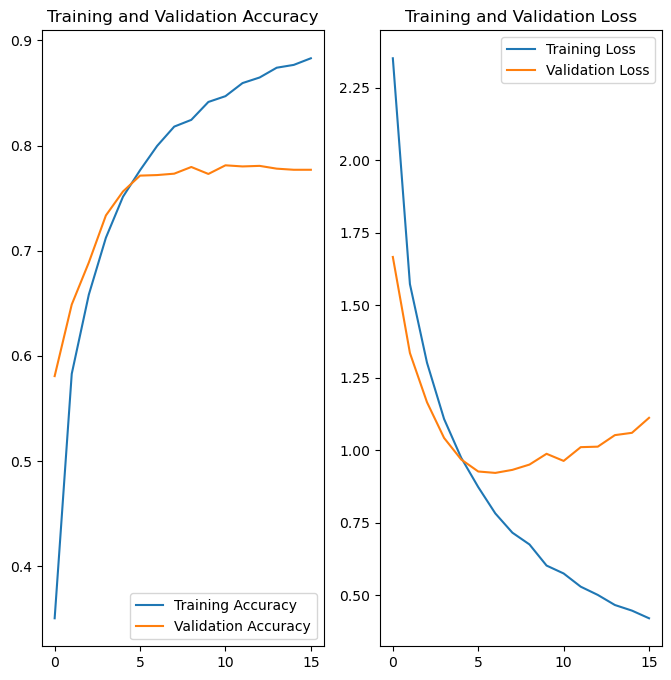

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

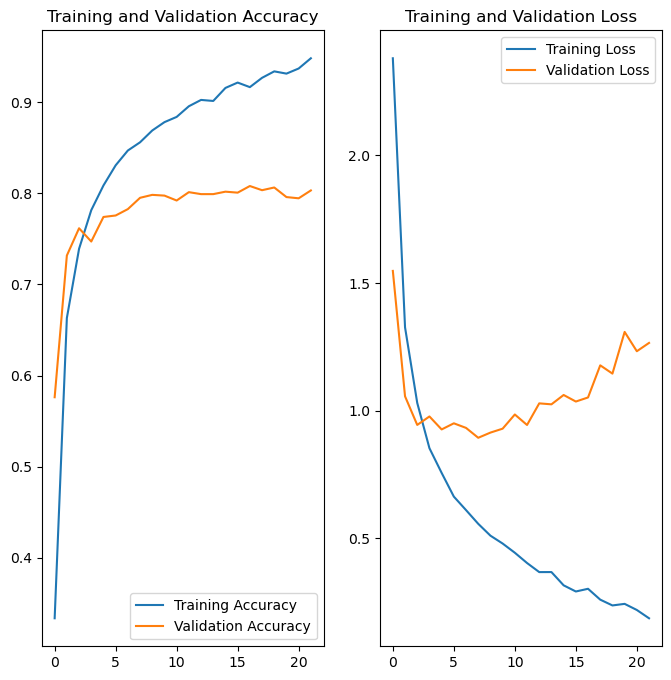

In [83]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(history2.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The value of the loss function at a given epoch quantifies the difference between the predicted outputs of the algorithm and the actual target values; in other words, it is the penalty for a incorrect prediction magnified by how incorrect the prediction was.

Accuracy is a metric used to measure how often the model correctly predicts the outcome; Acc = # Correct Predictions / # Total Predictions.

The validation loss and validation accuracy values resulting from applying the models on the testing set indicate that both algorithms are reasonably effective at classifying medical diagnoses/treatments from text data.

2/2 [==============================] - 0s 158ms/step


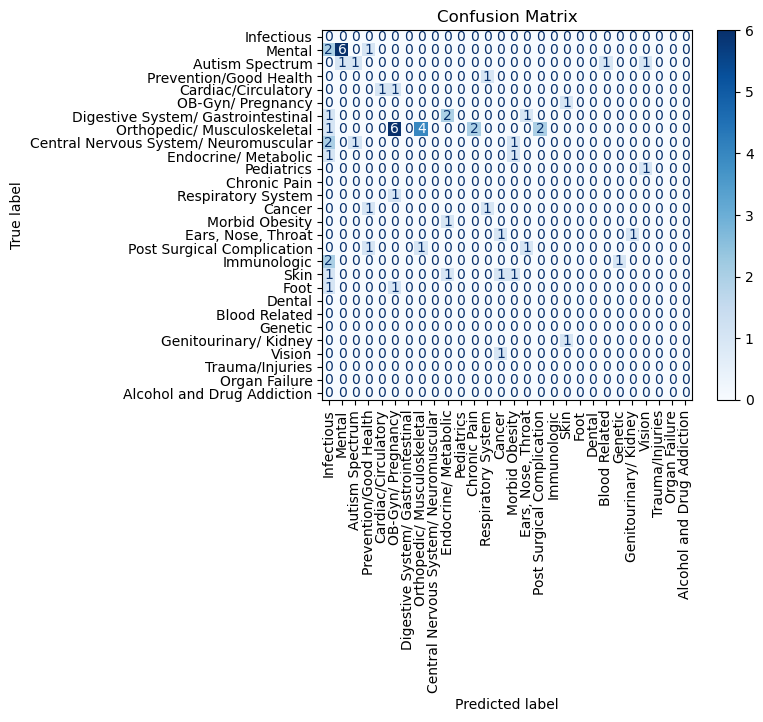

In [126]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for x_batch, y_batch in diagnosis_test_ds:
    predictions = treatment_model.predict(x_batch)
    predicted_classes = np.argmax(predictions, axis=1)
    
    true_classes = np.argmax(y_batch.numpy(), axis=1)
    
    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(diagnostic_categories)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=diagnostic_categories)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(np.arange(len(classes)), diagnostic_categories, rotation=90)
plt.yticks(np.arange(len(classes)), diagnostic_categories)

plt.title('Confusion Matrix')
plt.show()

Confusion Matrix: also known as an error matrix, a matrix representation of model testing results allowing for the identification of classes that the algorithm is 'confusing' or misidentifying for another class(es). The confusion matrix here does not suggest any serious issues in the algorithm.

In [136]:
class_indices = np.arange(len(diagnostic_categories))

report = classification_report(
    y_true, y_pred, labels=class_indices, target_names=diagnostic_categories, zero_division=0
)

print(report)

                                       precision    recall  f1-score   support

                           Infectious       0.86      0.95      0.90        19
                               Mental       1.00      0.92      0.96        13
                      Autism Spectrum       0.50      1.00      0.67         1
               Prevention/Good Health       0.62      1.00      0.77         5
                  Cardiac/Circulatory       1.00      0.50      0.67         2
                    OB-Gyn/ Pregnancy       1.00      0.67      0.80         3
   Digestive System/ Gastrointestinal       0.00      0.00      0.00         0
          Orthopedic/ Musculoskeletal       0.67      0.67      0.67         3
Central Nervous System/ Neuromuscular       0.00      0.00      0.00         3
                 Endocrine/ Metabolic       0.00      0.00      0.00         3
                           Pediatrics       1.00      1.00      1.00         1
                         Chronic Pain       1.00   

Precision: a metric which measures model performance in terms of quality; calculated as the ratio between the number of 'True Positives' and the sum of the number of 'True Positives' and the number of 'False Positives'; a high precision indicates that the model returns more relevant or 'precise' results than irrelevant ones.

Recall: a metric which measures model performance in terms of quantity; calculated as the ratio between the number of 'True Positives' and the sum of the number of 'True Positives' and the number of 'False Negatives'; a high recall indicates that the model returns most of the relevant results, regardless of how many irrelevant results are also returned.

F1-Score: measures predictive model performance by integrating precision and recall into a single metric; calculated as the harmonic mean of the precision and recall scores; ranges from 0 to 1, with 0 indicating poor performance and 1 indicating perfect performance.

2/2 [==============================] - 0s 127ms/step


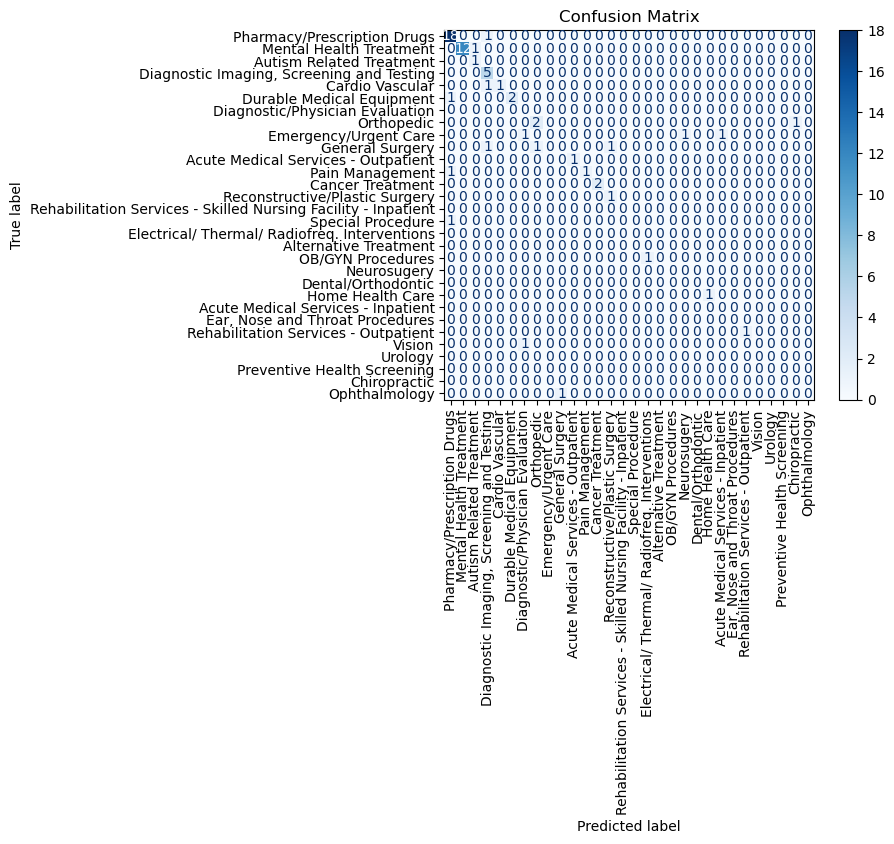

In [142]:
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    predictions = treatment_model.predict(x_batch)
    predicted_classes = np.argmax(predictions, axis=1)
    
    true_classes = np.argmax(y_batch.numpy(), axis=1)
    
    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(treatment_categories)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=treatment_categories)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(np.arange(len(treatment_categories)), treatment_categories, rotation=90)
plt.yticks(np.arange(len(treatment_categories)), treatment_categories)

plt.title('Confusion Matrix')
plt.show()

In [144]:
class_indices = np.arange(len(treatment_categories))

report = classification_report(
    y_true, y_pred, labels=class_indices, target_names=treatment_categories, zero_division=0
)

print(report)

                                                                precision    recall  f1-score   support

                                   Pharmacy/Prescription Drugs       0.86      0.95      0.90        19
                                       Mental Health Treatment       1.00      0.92      0.96        13
                                      Autism Related Treatment       0.50      1.00      0.67         1
                     Diagnostic Imaging, Screening and Testing       0.62      1.00      0.77         5
                                               Cardio Vascular       1.00      0.50      0.67         2
                                     Durable Medical Equipment       1.00      0.67      0.80         3
                               Diagnostic/Physician Evaluation       0.00      0.00      0.00         0
                                                    Orthopedic       0.67      0.67      0.67         3
                                         Emergency/Urgent Care 

Given the reasomably high high F1-scores overall and a high test accuracy of 93%, along with measures in place to safeguard against overfitting, it can be concluded that the models are reasonably effective at their respective classification tasks, with margin for improvement. The low macro averages reflect poorer model performance in the classes with less observations. The models could potentially improved by addressing class imbalance with oversampling techniques and tweaking model architecture in order to increase performance metrics.